# Proportional Historical Variance
Let's compare the relative magnitudes of the seasonal component and non-seasonal component of FG_CO2 in each region. Through climate diagnostics practices, this is quite simple: find the mean seasonal cycle historically and take the standard deviation of it ($\sigma_{s}$). Then find the mean standard deviation of all the residuals ($\sigma_{r}$). Then one can simply plot the proportion of variance explained by internal variability : $\frac{\sigma_{r}}{\sigma_{s} + \sigma{r}}$

In [1]:
import glob

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
plt.style.use('ocn-clim')
import cmocean.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Functions

In [2]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

In [3]:
def remove_polynomial_fit(data):
    """
    Takes in a time series and removes a polynomial fit, returning the detrended time series.
    """
    x = np.arange(0, len(data), 1)
    coefs = poly.polyfit(x, data, 4)
    line_fit = poly.polyval(x, coefs)
    unfitted = data - line_fit
    return xr.DataArray(unfitted)

In [4]:
def visual_bounds(EBU):
    """
    Zooms the map into the appropriate region for plotting the EBU of choice.
    """
    if EBU == "CalCS":
        lat1 = 34
        lat2 = 46
        lon1 = -135+360
        lon2 = -113+360
    elif EBU == 'HumCS':
        lat1 = -18
        lat2 = -4
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 25
        lon1 = -24
        lon2 = -11
    elif EBU == 'BenCS':
        lat1 = -30
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [5]:
def setup_map(ax, lat1, lat2, lon1, lon2):
    """
    Sets up our Basemap projection for plotting.
    """
    m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='c')
    m.fillcontinents(color='#D3D3D3')
    return m

In [6]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# (0) Can we make a strong case to just investigate the natural flux of CO$_{2}$ for awhile?

A decent starting point would be to map/quantify the variability due to natural carbon and the variability due to anthropogenic carbon. What's the relative proportion that is natural?

**NOTE** : Need to wait until I re-run the EBUS_Extraction and residuals stuff on the new data. I might have changed the way this was handled before, since it creates two different overhead grids.

In [ ]:
EBU = 'CalCS'

In [ ]:
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=False)
con_mean, con_resid, con_total = load_in_filtered_data('FG_CO2', EBU, AW=False)
ant_mean, ant_resid, ant_total = load_in_filtered_data('FG_ANT_CO2', EBU, AW=False)

# (1) How much of the spatial variability is internal vs. seasonal?
Let's split the natural carbon flux into it's seasonal variability component and internal variability component. We can then make maps of the relative contribution of the non-seasonal component.

In [ ]:
EBU = 'CalCS'

In [ ]:
# Start by illustrating the methodology on a box-averaged situation to prove you're doing it right.
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU)

# Detrend to get a zero-centered seasonality.
nat_seasonal_cycle = nat_mean.apply(remove_polynomial_fit)

# Compute the "average" seasonal cycle
nat_seasonality = nat_seasonal_cycle.groupby('time.month').mean(dim='time')

# Compute the magnitude of this seasonal cycle.
s_magnitude = nat_seasonality['FG_ALT_CO2_AW'].std()

In [ ]:
fig = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
nat_seasonality['FG_ALT_CO2_AW'].plot(color='k')
ax.set(title=EBU + ' F$_{\mathrm{Nat}}$ Seasonal Cycle',
       xticks=np.arange(1,13,1), ylabel='Natural CO$_{2}$ Flux')
ax.text(1, 1, '$\sigma$ = ' + str(s_magnitude.values.round(3)), size='x-large')
#plt.savefig(EBU + '_Seasonal_Cycle.png', transparent=True, dpi=300,
#            bbox_inches='tight', pad_inches=1)

In [ ]:
# Compute the magnitude of internal variability
r_magnitude = nat_resid['FG_ALT_CO2_AW'].std(dim='time').mean()

In [ ]:
fig = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
for i in np.arange(0, 34, 1):
    nat_resid['FG_ALT_CO2_AW'][i].plot(color='#D3D3D3', linewidth=2)
ax.set(xlim=['1920','2015'], title=EBU + ' F$_{\mathrm{Nat}}$ Residuals',
       ylabel='Natural CO$_{2}$ Flux', xlabel='')
ax.text('1925', 1, '$\sigma$ = ' + str(r_magnitude.values.round(3)),
        size='x-large')
#plt.savefig(EBU + '_Residual_Spread.png', transparent=True, dpi=300,
#            bbox_inches='tight', pad_inches=1)

In [ ]:
non_seasonal_variability = r_magnitude / (s_magnitude + r_magnitude)
print("The non-seasonal component of variability is : " + str(non_seasonal_variability.values.round(3)))

# (2) What do these two analyses look like on a grid cell basis?

### Computing the Relative Magnitudes

In [ ]:
EBU = 'BenCS'

In [ ]:
import numpy.polynomial.polynomial as poly
def seasonal_magnitude(ds):
    """
    This operation takes in an ensemble mean, assuming there's some seasonal cycle component
    and some trend component. It then detrends this mean with a 4th order fit to make it stationary.
    It'll finally take the standard deviation of the climatological mean seasonal cycle and return
    a grid of values that represent the magnitude of the seasonal cycle.
    """
    # We have some NaN time series here from our bounding box. 
    # Just ignore these because we can't fit them with any curve.
    if ds.min().isnull():
        return xr.DataArray(np.nan)
    else:
        # First, detrend this beast!
        x = np.arange(0, len(ds), 1)
        coefs = poly.polyfit(x, ds, 4)
        poly_fit = poly.polyval(x, coefs)
        seasonality = ds - poly_fit
        # Next, find the climatological seasonal cycle.
        magnitude = seasonality.groupby('time.month').mean().std()
        return xr.DataArray(magnitude)

In [ ]:
# Bring down full grid
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=False)

In [ ]:
# Compute the seasonal magnitude component
stacked = nat_mean['FG_ALT_CO2'].stack(allpoints=['nlat', 'nlon'])
operation = stacked.groupby('allpoints', squeeze=False).apply(seasonal_magnitude)
s_magnitude = operation.unstack('allpoints')

In [ ]:
# Compute the mean internal magnitude component
r_magnitude = nat_resid['FG_ALT_CO2'].std(dim='time').mean(dim='ensemble')

In [ ]:
# Create relative contribution.
relative_internal = (r_magnitude / (r_magnitude + s_magnitude)) * 100

In [ ]:
# Data to plot
lat = relative_internal['TLAT'].values
lon = relative_internal['TLONG'].values
data = relative_internal.to_masked_array()

# Figure Setup
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lat1,lat2,lon1,lon2 = visual_bounds(EBU)
m = setup_map(ax,lat1,lat2,lon1,lon2)

# Visualize
m.pcolor(lon-0.5, lat, data, vmin=0, vmax=100, latlon=True,
         cmap=discrete_cmap(10, 'BrBG_r'), edgecolor='w')
m.colorbar(location='bottom', ticks=[0,25,50,75,100],
          label='Non-Seasonal Variability [%]')
ax.set_title('Fraction of F$_{\mathrm{Nat}}$ Due to Internal Variability', fontsize='x-large')

# Save plot
#plt.savefig('fractional_internal_variability_FG_ALT_CO2_' + EBU + '.png',
#            bbox_inches='tight', pad_inches=1, transparent=True, dpi=300)

# (3) What does this look like when we involve the trend?
Can we make some plots comparing the long-term anthropogenic trend?

** Note **: Will do this once I get my hands on the FG_ANT_CO2 output.

# (4) How does the non-seasonal variability look relative to large ocean basins?

Nikki wants to make a point that these systems are anomalously high in internal variability. Going to try two approaches to this:

1. Make a global map of the non-seasonal variability and see if these pop out.
2. Use REGION_MASK to compute these on an area-weighted scale and then make bar plots.

### Global Map Approach
Note that I applied the seasonal_magnitude function to the entire global grid of ensemble mean FG_ALT_CO2. I just removed those cells to keep this notebook clean, since I saved the output to a netcdf.

In [7]:
fileDir = '/glade/u/home/rbrady/work/EBUS_BGC_Variability/FG_ALT_CO2/global/proportional_internal_variability_global.nc'
ds = xr.open_dataset(fileDir)

In [8]:
def make_cartopy(projection=ccrs.Robinson(central_longitude=0), 
                 figsize=(12, 8), resolution='1000m'):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    ax.set_global()
    gl = ax.gridlines(draw_labels=False)
    ax.add_feature(cfeature.LAND, facecolor='k')
    return fig, ax

In [9]:
def visual_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 34
        lat2 = 44
        lon1 = -133
        lon2 = -115
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = -2
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 12
        lat2 = 22
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -28
        lat2 = -18
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [58]:
def deseam(lon, lat, data):
    """
    Simple way to get rid of the "seam" that occurs at the wrapping point for longitude. 
    Just adds an extra column of copy cat data for it to wrap over.    
    
    Note: This is optimized for a 2D grid. So either input a meshgrid or a native 2D grid. 
    """
    i, j = lat.shape
    new_lon = np.zeros((i, j+1))
    new_lon[:, :-1] = lon
    new_lon[:, -1] = lon[:, 0]

    new_lat = np.zeros((i, j+1))
    new_lat[:, :-1] = lat
    new_lat[:, -1] = lat[:, 0]

    new_data = np.zeros((i, j+1))
    new_data[:, :-1] = data
    new_data[:, -1] = data[:, 0]
    return new_lon, new_lat, new_data

In [10]:
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']

In [60]:
data = ds['relative_internal']
lon = ds['TLONG']
lat = ds['TLAT']

In [62]:
lon, lat, data = deseam(lon, lat, data)

/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


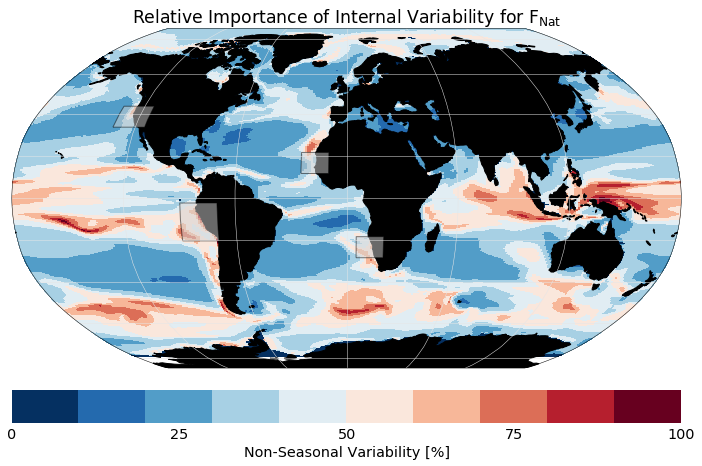

In [68]:
from shapely.geometry.polygon import LinearRing


fig, ax = make_cartopy()
m = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
                  vmin=0, vmax=100, cmap=discrete_cmap(10, 'RdBu_r'))
cb = plt.colorbar(m, ax=ax, orientation='horizontal', pad=0.05,
                  ticks=[0,25,50,75,100])
ax.set_title('Relative Importance of Internal Variability for F$_{\mathrm{Nat}}$')
cb.set_label('Non-Seasonal Variability [%]')

# Add boxes over the systems.
for idx in EBUS:
    lat1,lat2,lon1,lon2 = visual_bounds(idx)
    lons = [lon1, lon1, lon2, lon2]
    lats = [lat1, lat2, lat2, lat1]
    ring = LinearRing(list(zip(lons, lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='#d3d3d3', edgecolor='black',
                      linewidth=2, alpha=0.5)
    
#plt.savefig('global_importance_of_internal_Fnat.png', transparent=True,
#           bbox_inches='tight', pad_inches=1, dpi=500)